In [183]:
#Import all required libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score,recall_score,confusion_matrix,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as m
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn import cross_validation   #Additional sklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.preprocessing import LabelEncoder

#Not a new window
%matplotlib inline
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

In [193]:
#Creation of categorical variables from the data set

def preprocess_inputs(df):
    #Convert to categories
    df['AgeGroup'] = 0
    df.loc[(df['age'] >= 17) & (df['age'] <= 23),'AgeGroup'] = '17-23'
    df.loc[(df['age'] >= 24) & (df['age'] <= 35),'AgeGroup'] = '24-35'
    df.loc[(df['age'] >= 36) & (df['age'] <= 55),'AgeGroup'] = '36-55'
    df.loc[df['age'] > 55,'AgeGroup'] = '55++'
    df.loc[(df['education'] == 'basic.4y') | (df['education'] == 'basic.6y') | (df['education'] == 'basic.9y'),'education'] = 'basic'
    df.loc[(df['campaign'] > 4),'campaign'] = '4+'
    df.loc[(df['previous'] ==0),'previous'] = 'NC'
    df.loc[(df['previous'] <> 'NC' ),'previous'] = 'C'
    #Scale the numeric variables between -1 and 1
    scaler = StandardScaler()
    df['emp.var.rate'] = scaler.fit_transform(df['emp.var.rate'].values.reshape(-1,1))
    df['cons.price.idx'] = scaler.fit_transform(df['cons.price.idx'].values.reshape(-1,1))
    df['cons.conf.idx'] = scaler.fit_transform(df['cons.conf.idx'].values.reshape(-1,1))
    df['nr.employed'] = scaler.fit_transform(df['nr.employed'].values.reshape(-1,1))
    df['euribor3m'] = scaler.fit_transform(df['euribor3m'].values.reshape(-1,1))
    #Impute missing variables and delete the highly co-related and un-neccessary inputs
    df['job'] = df['job'].fillna(df['job'].mode()[0])
    df['education'] = df['education'].fillna(df['education'].mode()[0])
    df['loan'] = df['loan'].fillna(df['loan'].mode()[0])
    #Delete variables that are not required  
    del df['duration']
    del df['pdays']
    df.drop(df[['age']],axis=1,inplace=True)
    # Encode the categorical variables
    encoder = LabelEncoder()
    df['AgeGroup'] = encoder.fit_transform(df['AgeGroup'])
    df['poutcome'] = encoder.fit_transform(df['poutcome'])
    df['education'] = encoder.fit_transform(df['education'])
    df['campaign'] = encoder.fit_transform(df['campaign'])
    df['previous'] = encoder.fit_transform(df['previous'])
    df['job'] = encoder.fit_transform(df['job'])
    df['loan'] = encoder.fit_transform(df['loan'])
    df['month'] = encoder.fit_transform(df['month'])
    df['day_of_week'] = encoder.fit_transform(df['day_of_week'])
    df['contact'] = encoder.fit_transform(df['contact'])
    #Hot encode
    df = pd.get_dummies(df,columns=['default','housing','marital'])
    #Map no=0 and yes=1 for y
    df['y'] = df['y'].map(dict(yes=1, no=0))
    return df

#Test the different models on the dataset
def test_models(X,y):
    #List of classifier models to test
    classifiers = {'Gradient Boosting Classifier':GradientBoostingClassifier(),'Adaptive Boosting Classifier':AdaBoostClassifier(),'Linear Discriminant Analysis':LinearDiscriminantAnalysis(),'Logistic Regression':LogisticRegression(),'Random Forest Classifier': RandomForestClassifier(),'K Nearest Neighbour':KNeighborsClassifier(8)}
    #Get the input variables and target variables for testing
    data_y = y
    data_X = X
    #Print the headers
    print(data_X.columns)
    log_cols = ["Classifier", "Accuracy","Precision Score","Recall Score","F1-Score","roc-auc_Score"]
    log = pd.DataFrame(columns=log_cols)
    #Filter the ignore warnings
    import warnings
    warnings.filterwarnings('ignore')
    #Random splitting to check over-fitting in testing the models
    rs = StratifiedShuffleSplit(n_splits=5, test_size=0.2,random_state=0)
    rs.get_n_splits(data_X,data_y)
    for Name,classify in classifiers.items():
        for train_index, test_index in rs.split(data_X,data_y):
            X,X_test = data_X.iloc[train_index], data_X.iloc[test_index]
            y,y_test = data_y.iloc[train_index], data_y.iloc[test_index]

            cls = classify
            cls =cls.fit(X,y)

            y_out = cls.predict(X_test)

            accuracy = m.accuracy_score(y_test,y_out)
            precision = m.precision_score(y_test,y_out,average='macro')
            recall = m.recall_score(y_test,y_out,average='macro')
            roc_auc = roc_auc_score(y_out,y_test)
            f1_score = m.f1_score(y,y_out,average='macro')
            #conf = metrics.confusion_matrix(y, y_out)

            log_entry = pd.DataFrame([[Name,accuracy,precision,recall,f1_score,roc_auc]], columns=log_cols)
            log = log.append(log_entry)
    print(log)
    plt.xlabel('Accuracy')
    plt.title('Classifier Accuracy')
    sns.set_color_codes("muted")
    sns.barplot(x='Accuracy', y='Classifier', data=log, color="g")  
    plt.show()

#Test  a specific model for performance
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, y)
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    f1_score = metrics.f1_score(y,dtrain_predictions,average='macro')
    conf = metrics.confusion_matrix(y, dtrain_predictions)
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)
    print "F1 Score: ", f1_score
    print conf
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))   
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
        fig, ax = plt.subplots(figsize=(15,10))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [191]:
data = pd.read_csv("./bank-additional-full.csv", sep=';',na_values=["unknown"],doublequote=True)
data = preprocess_inputs(data)

# Separating inputs and target variables
X = data.drop(['y'], axis=1)
y = data['y']

In [194]:
test_models(X,y)

Index([u'job', u'education', u'loan', u'contact', u'month', u'day_of_week',
       u'campaign', u'previous', u'poutcome', u'emp.var.rate',
       u'cons.price.idx', u'cons.conf.idx', u'euribor3m', u'nr.employed',
       u'AgeGroup', u'default_no', u'default_yes', u'housing_no',
       u'housing_yes', u'marital_divorced', u'marital_married',
       u'marital_single'],
      dtype='object')


ValueError: Found input variables with inconsistent numbers of samples: [32950, 8238]


Model Report
Accuracy : 0.9041
AUC Score (Train): 0.810109
CV Score : Mean - 0.8010242 | Std - 0.007395421 | Min - 0.7928817 | Max - 0.8135576


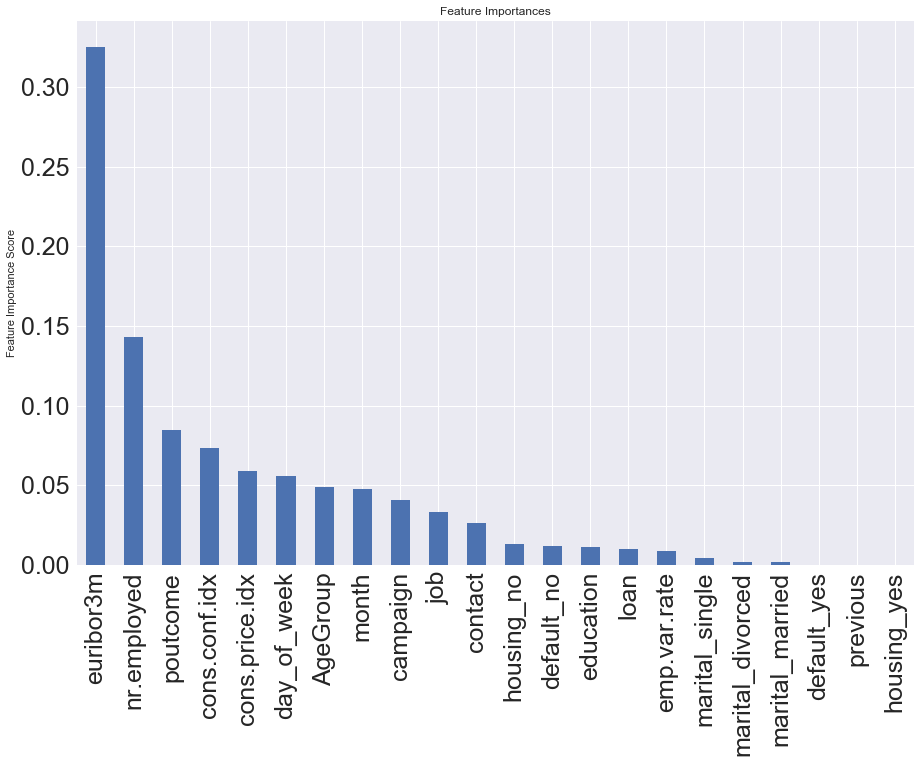

In [114]:
#Choose all predictors except target
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X, y)

In [115]:
X.head()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32950 entries, 15434 to 29296
Data columns (total 22 columns):
job                 32950 non-null int64
education           32950 non-null int64
loan                32950 non-null int64
contact             32950 non-null int64
month               32950 non-null int64
day_of_week         32950 non-null int64
campaign            32950 non-null int64
previous            32950 non-null int64
poutcome            32950 non-null int64
emp.var.rate        32950 non-null float64
cons.price.idx      32950 non-null float64
cons.conf.idx       32950 non-null float64
euribor3m           32950 non-null float64
nr.employed         32950 non-null float64
AgeGroup            32950 non-null int64
default_no          32950 non-null uint8
default_yes         32950 non-null uint8
housing_no          32950 non-null uint8
housing_yes         32950 non-null uint8
marital_divorced    32950 non-null uint8
marital_married     32950 non-null uint8
marital_single  

In [116]:
#BASELINE:
#High learning rate default value of 0.1 works but somewhere between 0.05 to 0.2.
#optimum number of trees for this learning rate should range around 40-70. Remember to choose a value on which your system can work fairly fast. 
#Lower the learning rate and increase the estimators proportionally to get more robust models.


#min_samples_split = 400 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
#min_samples_leaf = 30 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
#max_depth = 5 : Should be chosen (5-8) based on the number of observations and predictors. This is because they have 87K rows and 49 columns so lets take 8 here.
#max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
#subsample = 0.8 : This is a commonly used used start value

param_test1 = {'n_estimators':range(70,151,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=400,min_samples_leaf=30,max_depth=5,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=30,
              min_samples_split=400, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [70, 80, 90, 100, 110, 120, 130, 140, 150]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [118]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.80103, std: 0.00830, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.80120, std: 0.00912, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.80071, std: 0.00831, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.80062, std: 0.00827, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.80099, std: 0.00894, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.80172, std: 0.00942, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.80238, std: 0.00850, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.80184, std: 0.00862, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.80242, std: 0.00928, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.80182, std: 0.00934, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.79939, std: 0.00899, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.80105, std: 0.00920, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [119]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=120,max_depth=7,max_features='sqrt', subsample=0.8, random_state=10, min_samples_split=800), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X,y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.80198, std: 0.00889, params: {'min_samples_split': 1000, 'min_samples_leaf': 30},
  mean: 0.80188, std: 0.00943, params: {'min_samples_split': 1200, 'min_samples_leaf': 30},
  mean: 0.80187, std: 0.00863, params: {'min_samples_split': 1400, 'min_samples_leaf': 30},
  mean: 0.80198, std: 0.00920, params: {'min_samples_split': 1600, 'min_samples_leaf': 30},
  mean: 0.80145, std: 0.00866, params: {'min_samples_split': 1800, 'min_samples_leaf': 30},
  mean: 0.80135, std: 0.00839, params: {'min_samples_split': 2000, 'min_samples_leaf': 30},
  mean: 0.80146, std: 0.00912, params: {'min_samples_split': 1000, 'min_samples_leaf': 40},
  mean: 0.80134, std: 0.00927, params: {'min_samples_split': 1200, 'min_samples_leaf': 40},
  mean: 0.80170, std: 0.00928, params: {'min_samples_split': 1400, 'min_samples_leaf': 40},
  mean: 0.80192, std: 0.00977, params: {'min_samples_split': 1600, 'min_samples_leaf': 40},
  mean: 0.80201, std: 0.00957, params: {'min_samples_split': 1800, 'min_samples_

In [120]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=7, min_samples_split=2000, min_samples_leaf=50, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X,y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.80275, std: 0.00883, params: {'max_features': 7},
  mean: 0.80270, std: 0.00887, params: {'max_features': 9},
  mean: 0.80377, std: 0.00822, params: {'max_features': 11},
  mean: 0.80429, std: 0.00862, params: {'max_features': 13},
  mean: 0.80345, std: 0.00893, params: {'max_features': 15},
  mean: 0.80380, std: 0.00834, params: {'max_features': 17},
  mean: 0.80456, std: 0.00886, params: {'max_features': 19}],
 {'max_features': 19},
 0.8045607639312603)

In [121]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=7,min_samples_split=2000, min_samples_leaf=50, subsample=0.8, random_state=10,max_features=19),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X,y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.80393, std: 0.00820, params: {'subsample': 0.6},
  mean: 0.80332, std: 0.00865, params: {'subsample': 0.7},
  mean: 0.80422, std: 0.00852, params: {'subsample': 0.75},
  mean: 0.80456, std: 0.00886, params: {'subsample': 0.8},
  mean: 0.80387, std: 0.00870, params: {'subsample': 0.85},
  mean: 0.80389, std: 0.00875, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.8045607639312603)


Model Report
Accuracy : 0.9036
AUC Score (Train): 0.820646
F1 Score:  0.661322833488
[[28819   419]
 [ 2759   953]]
CV Score : Mean - 0.8050044 | Std - 0.008780503 | Min - 0.7964538 | Max - 0.8194244


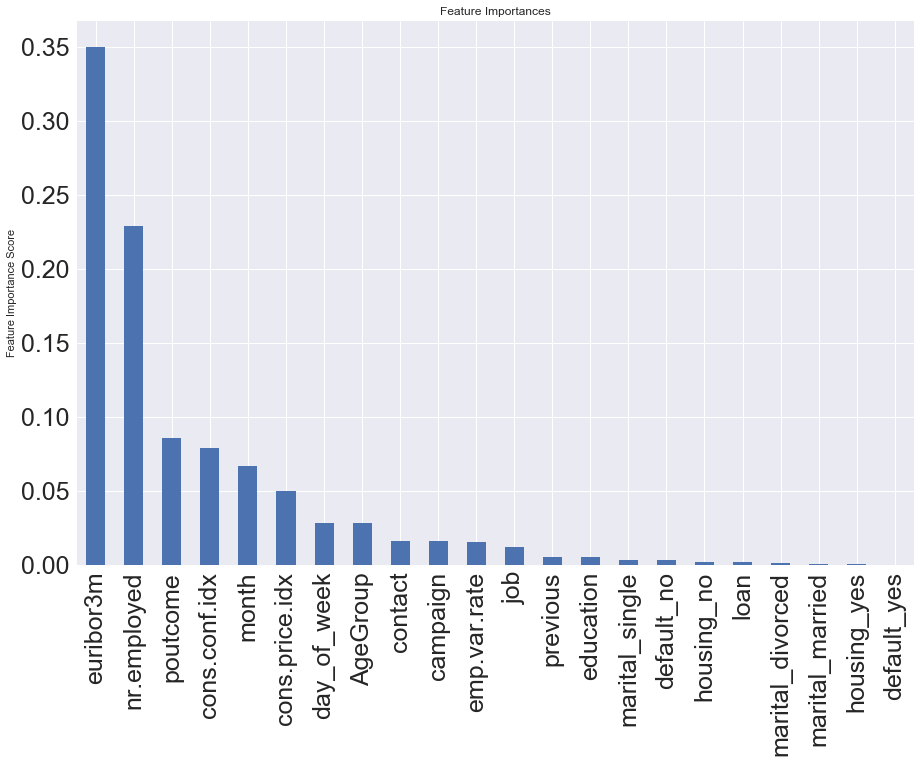

In [131]:
#Decrease the learning rate to half, i.e. 0.05 with twice (200) the number of trees. And keep doing this.
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=140,max_depth=7, min_samples_split=2000,min_samples_leaf=50, subsample=0.8, random_state=10, max_features=19)
modelfit(gbm_tuned_1, X, y)